# Homework 5
**name:** Mina Stojanovic  
**github id:** minastoj  
**USC student id:** 4968308304  

In [160]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [146]:
import pandas as pd
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import _tree
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

### Question 1
#### Decision Trees as Interpretable Models
(a) Download the Accute Inflamations data from https://archive.ics.uci.edu/ml/datasets/Acute+Inflammations.  
(b) Build a decision tree on the whole data set and plot it.

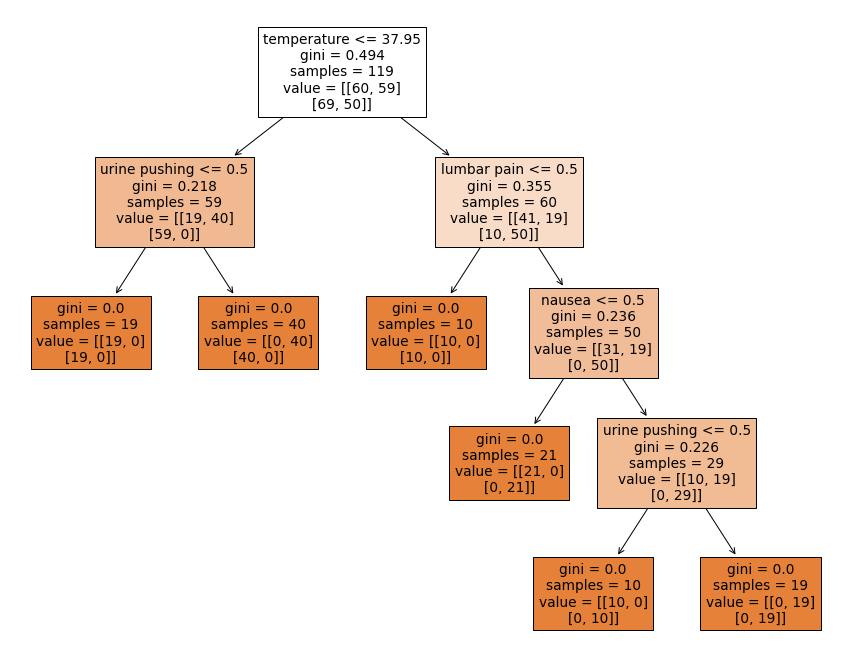

In [147]:
# columns names for each attribute from diagnosis.names
columns = ['temperature', 'nausea', 'lumbar pain', 'urine pushing', 'micturition pains', 'burning of urethra', 'inflamation', 'nephritis']
features = columns[:-2]
targets = columns[-2:] # last two columns are decision attributes

# REFERENCE: Site #1
data = pd.read_csv('../data/diagnosis.data', header=0, delim_whitespace=True, encoding='utf-16')
data.columns = columns

# map yes to 1 and no to 0 (might be necessary)
transition = {'yes': 1, 'no': 0}

for attrib in columns:
    if(attrib == 'temperature'):
        # convert all temperatures to floats with decimals
        for i in range(len(data[attrib])):
            temp = data[attrib][i].split(',')
            data[attrib][i] = temp[0] + '.' + temp[1]
            data[attrib][i] = float(data[attrib][i])
    else:
        data[attrib] = data[attrib].map(transition)

X = data[features]
Y = data[targets]

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X, Y)

plt.figure(figsize=(15, 12))
plot_tree(decision_tree, feature_names=features, filled=True)
plt.show()

(c) Convert the decision rules into a set of IF-THEN rules.

In [148]:
# REFERENCE: Site #2
def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    feature_names = [f.replace(" ", "_")[:-5] for f in feature_names]
    print("def predict({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "    " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, np.round(threshold,2)))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, np.round(threshold,2)))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

tree_to_code(decision_tree, features)

def predict(temper, n, lumbar, urine_pu, micturition_, burning_of_ur):
    if temperature <= 37.95:
        if urine pushing <= 0.5:
            return [[19.  0.]
 [19.  0.]]
        else:  # if urine pushing > 0.5
            return [[ 0. 40.]
 [40.  0.]]
    else:  # if temperature > 37.95
        if lumbar pain <= 0.5:
            return [[10.  0.]
 [10.  0.]]
        else:  # if lumbar pain > 0.5
            if nausea <= 0.5:
                return [[21.  0.]
 [ 0. 21.]]
            else:  # if nausea > 0.5
                if urine pushing <= 0.5:
                    return [[10.  0.]
 [ 0. 10.]]
                else:  # if urine pushing > 0.5
                    return [[ 0. 19.]
 [ 0. 19.]]


(d) Use cost-complexity pruning to find a minimal decision tree and a set of decision rules with high interpretability.

Best alpha: 1e-05
Best score: 0.9583


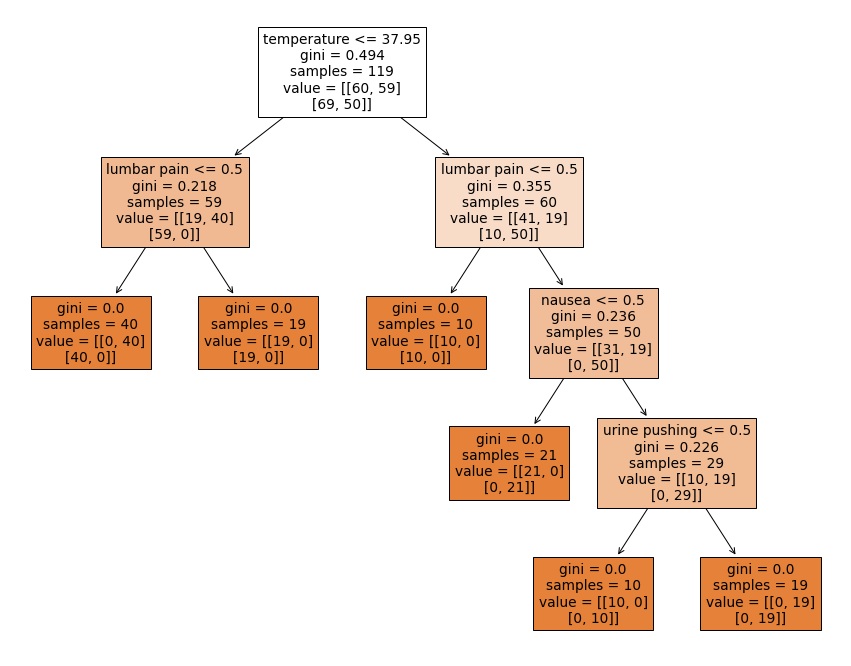

In [149]:
# REFERENCE: Site #3
# alphas = np.linspace(0, 1, 20)
alphas = np.logspace(-5, 2, 1000)

param_grid = {'ccp_alpha': alphas}
grid_search = GridSearchCV(decision_tree, param_grid, cv=10)
grid_search.fit(X, Y)

best_alpha = grid_search.best_params_['ccp_alpha']

print("Best alpha:", best_alpha)
print(f"Best score: {grid_search.best_score_:.4f}")

decision_tree = DecisionTreeClassifier(ccp_alpha=best_alpha)
decision_tree.fit(X, Y)

plt.figure(figsize=(15, 12))
plot_tree(decision_tree, feature_names=features, filled=True)
plt.show()


### Question 2
#### The LASSO and Boosting for Regression
(a) Download the Communities and Crime data from https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime. Use the first 1495 rows of data as the training set and the rest as the test set.  
(b) The data set has missing values. Use a data imputation technique to deal with the missing values in the data set. The data description mentions some features are nonpredictive. Ignore those features.

In [150]:
# columns names for each attribute from communities.names
columns = [
    "state", "county", "community", "communityname", "fold", "population", "householdsize", "racepctblack", 
    "racePctWhite", "racePctAsian", "racePctHisp", "agePct12t21", "agePct12t29", "agePct16t24", "agePct65up", 
    "numbUrban", "pctUrban", "medIncome", "pctWWage", "pctWFarmSelf", "pctWInvInc", "pctWSocSec", "pctWPubAsst", 
    "pctWRetire", "medFamInc", "perCapInc", "whitePerCap", "blackPerCap", "indianPerCap", "AsianPerCap", 
    "OtherPerCap", "HispPerCap", "NumUnderPov", "PctPopUnderPov", "PctLess9thGrade", "PctNotHSGrad", 
    "PctBSorMore", "PctUnemployed", "PctEmploy", "PctEmplManu", "PctEmplProfServ", "PctOccupManu", 
    "PctOccupMgmtProf", "MalePctDivorce", "MalePctNevMarr", "FemalePctDiv", "TotalPctDiv", "PersPerFam", 
    "PctFam2Par", "PctKids2Par", "PctYoungKids2Par", "PctTeen2Par", "PctWorkMomYoungKids", "PctWorkMom", 
    "NumIlleg", "PctIlleg", "NumImmig", "PctImmigRecent", "PctImmigRec5", "PctImmigRec8", "PctImmigRec10", 
    "PctRecentImmig", "PctRecImmig5", "PctRecImmig8", "PctRecImmig10", "PctSpeakEnglOnly", "PctNotSpeakEnglWell", 
    "PctLargHouseFam", "PctLargHouseOccup", "PersPerOccupHous", "PersPerOwnOccHous", "PersPerRentOccHous", 
    "PctPersOwnOccup", "PctPersDenseHous", "PctHousLess3BR", "MedNumBR", "HousVacant", "PctHousOccup", 
    "PctHousOwnOcc", "PctVacantBoarded", "PctVacMore6Mos", "MedYrHousBuilt", "PctHousNoPhone", "PctWOFullPlumb", 
    "OwnOccLowQuart", "OwnOccMedVal", "OwnOccHiQuart", "RentLowQ", "RentMedian", "RentHighQ", "MedRent", 
    "MedRentPctHousInc", "MedOwnCostPctInc", "MedOwnCostPctIncNoMtg", "NumInShelters", "NumStreet", 
    "PctForeignBorn", "PctBornSameState", "PctSameHouse85", "PctSameCity85", "PctSameState85", "LemasSwornFT", 
    "LemasSwFTPerPop", "LemasSwFTFieldOps", "LemasSwFTFieldPerPop", "LemasTotalReq", "LemasTotReqPerPop", 
    "PolicReqPerOffic", "PolicPerPop", "RacialMatchCommPol", "PctPolicWhite", "PctPolicBlack", "PctPolicHisp", 
    "PctPolicAsian", "PctPolicMinor", "OfficAssgnDrugUnits", "NumKindsDrugsSeiz", "PolicAveOTWorked", 
    "LandArea", "PopDens", "PctUsePubTrans", "PolicCars", "PolicOperBudg", "LemasPctPolicOnPatr", 
    "LemasGangUnitDeploy", "LemasPctOfficDrugUn", "PolicBudgPerPop", "ViolentCrimesPerPop"
]

features = columns[:-1]
target = columns[-1] # final column is goal

# REFERENCE: Site #1
data = pd.read_csv('../data/communities.data', header=0, delimiter=',')
data.columns = columns

data = data.drop(columns=["state", "county", "community", "communityname", "fold"]) # these features are non-predictive
data.replace('?', np.nan, inplace=True) # '?' was causing issues with imputer, so replace with NaN

# REFERENCE: Site #4
# multivariate imputation
iterative_imputer = IterativeImputer(random_state=0)
data_imputed = pd.DataFrame(iterative_imputer.fit_transform(data), columns=data.columns)

training_set = data_imputed[:1495]
testing_set = data_imputed[1495:]

# first 1495 rows are training set & the rest are testing set
X_train = training_set[data_imputed.columns[:-1]]
Y_train = training_set[data_imputed.columns[-1]]

X_test = testing_set[data_imputed.columns[:-1]]
Y_test = testing_set[data_imputed.columns[-1]]

all_X = pd.concat([X_train, X_test])
all_Y = pd.concat([Y_train, Y_test])

(c) Plot a correlation matrix for the features in the data set.

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
population,1.000000,-0.045742,0.231594,-0.301269,0.181738,0.156202,0.006654,0.130468,0.075764,-0.101740,...,0.713630,0.231892,0.270344,0.803135,0.710260,-0.205619,0.120048,0.466091,-0.047117,0.367346
householdsize,-0.045742,1.000000,-0.067385,-0.235722,0.201965,0.468785,0.520365,0.367334,0.295166,-0.613055,...,-0.014877,-0.004018,-0.051446,-0.128178,-0.064270,-0.099187,0.021514,-0.094019,0.019214,-0.034995
racepctblack,0.231594,-0.067385,1.000000,-0.794350,-0.106800,-0.066552,0.122188,0.153438,0.133996,0.052761,...,0.149941,0.095105,0.147092,0.244456,0.061634,-0.188634,0.107196,0.261174,-0.145774,0.631279
racePctWhite,-0.301269,-0.235722,-0.794350,1.000000,-0.270243,-0.444241,-0.193883,-0.266828,-0.183741,0.136680,...,-0.131560,-0.337530,-0.215707,-0.235299,-0.153647,0.263063,-0.215800,-0.276603,0.055728,-0.684787
racePctAsian,0.181738,0.201965,-0.106800,-0.270243,1.000000,0.266754,-0.025066,0.100715,0.052740,-0.272091,...,-0.001044,0.389959,0.296938,0.015896,0.191482,-0.178300,0.187263,0.101987,0.169962,0.037609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LemasPctPolicOnPatr,-0.205619,-0.099187,-0.188634,0.263063,-0.178300,-0.111720,0.051720,-0.015051,0.042764,0.128799,...,-0.130312,-0.107578,-0.103209,-0.164877,-0.204975,1.000000,-0.059844,-0.169271,0.027113,-0.203581
LemasGangUnitDeploy,0.120048,0.021514,0.107196,-0.215800,0.187263,0.166806,0.098382,0.143723,0.091661,-0.163699,...,0.139805,-0.099913,-0.206622,0.167148,0.036094,-0.059844,1.000000,0.023058,0.086524,0.225520
LemasPctOfficDrugUn,0.466091,-0.094019,0.261174,-0.276603,0.101987,0.125329,0.001558,0.117396,0.083331,-0.009899,...,0.299481,0.228073,0.206612,0.343677,0.202760,-0.169271,0.023058,1.000000,-0.033257,0.348784
PolicBudgPerPop,-0.047117,0.019214,-0.145774,0.055728,0.169962,0.080624,-0.127946,-0.099222,-0.103422,-0.048671,...,-0.102263,0.071251,0.052526,0.138085,0.178891,0.027113,0.086524,-0.033257,1.000000,-0.031461


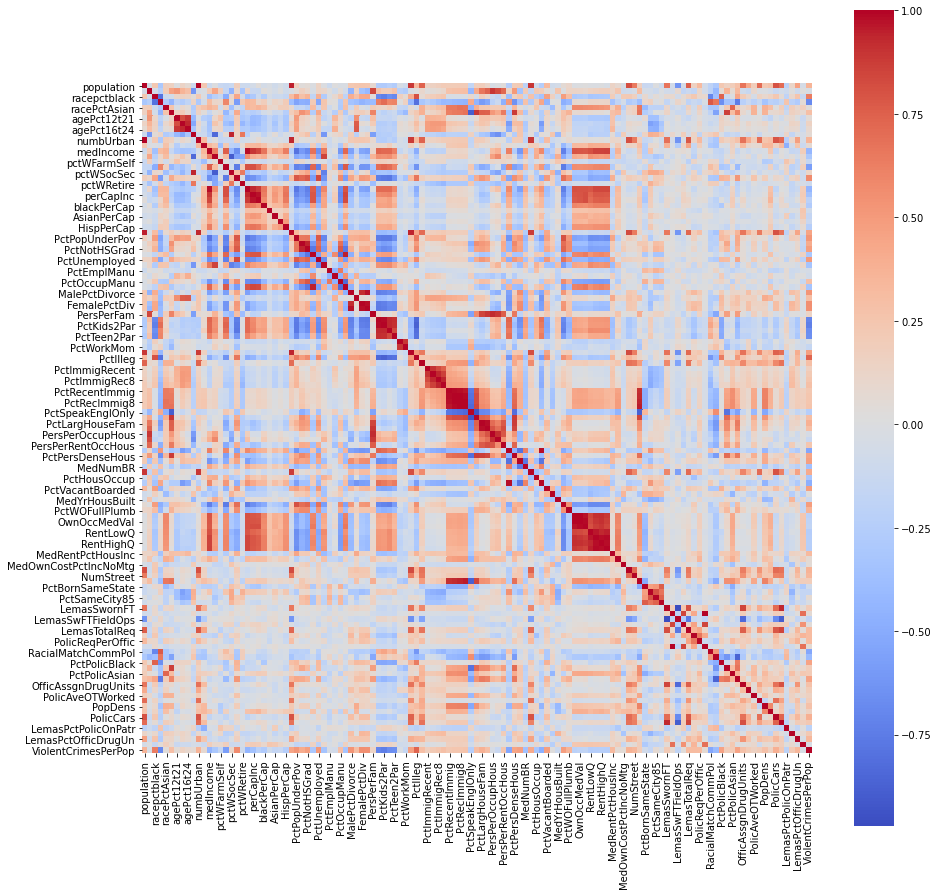

In [151]:
correlationMatrix = data_imputed.corr()

# wasn't sure if you wanted the chart or the plot, so I included both
display(correlationMatrix)

plt.figure(figsize=(15, 15))
sns.heatmap(correlationMatrix, annot=False, cmap="coolwarm", square=True)
plt.show()

(d) Calculate the Coefficient of Variation CV for each feature, where CV = s/m, in
which s is sample standard deviation and m is sample mean.

In [152]:
coefficients = [] # store coefficients of variation for each feature

for column in data_imputed.columns:
    std_dev = data_imputed[column].std()
    mean = data_imputed[column].mean()
    cv = std_dev / mean
    coefficients.append({"feature": column, "cv": cv})

coeff_df = pd.DataFrame(coefficients)
display(coeff_df)

,feature,cv
0,population,2.205998
1,householdsize,0.353277
2,racepctblack,1.410505
3,racePctWhite,0.323865
4,racePctAsian,1.359345
...,...,...
118,LemasPctPolicOnPatr,0.265086
119,LemasGangUnitDeploy,0.450650
120,LemasPctOfficDrugUn,2.558424
121,PolicBudgPerPop,0.402469


(e) Pick sqrt(128) features with highest CV, and make scatter plots and box plots for them. Can you draw conclusions about significance of those features, just by the scatter plots?

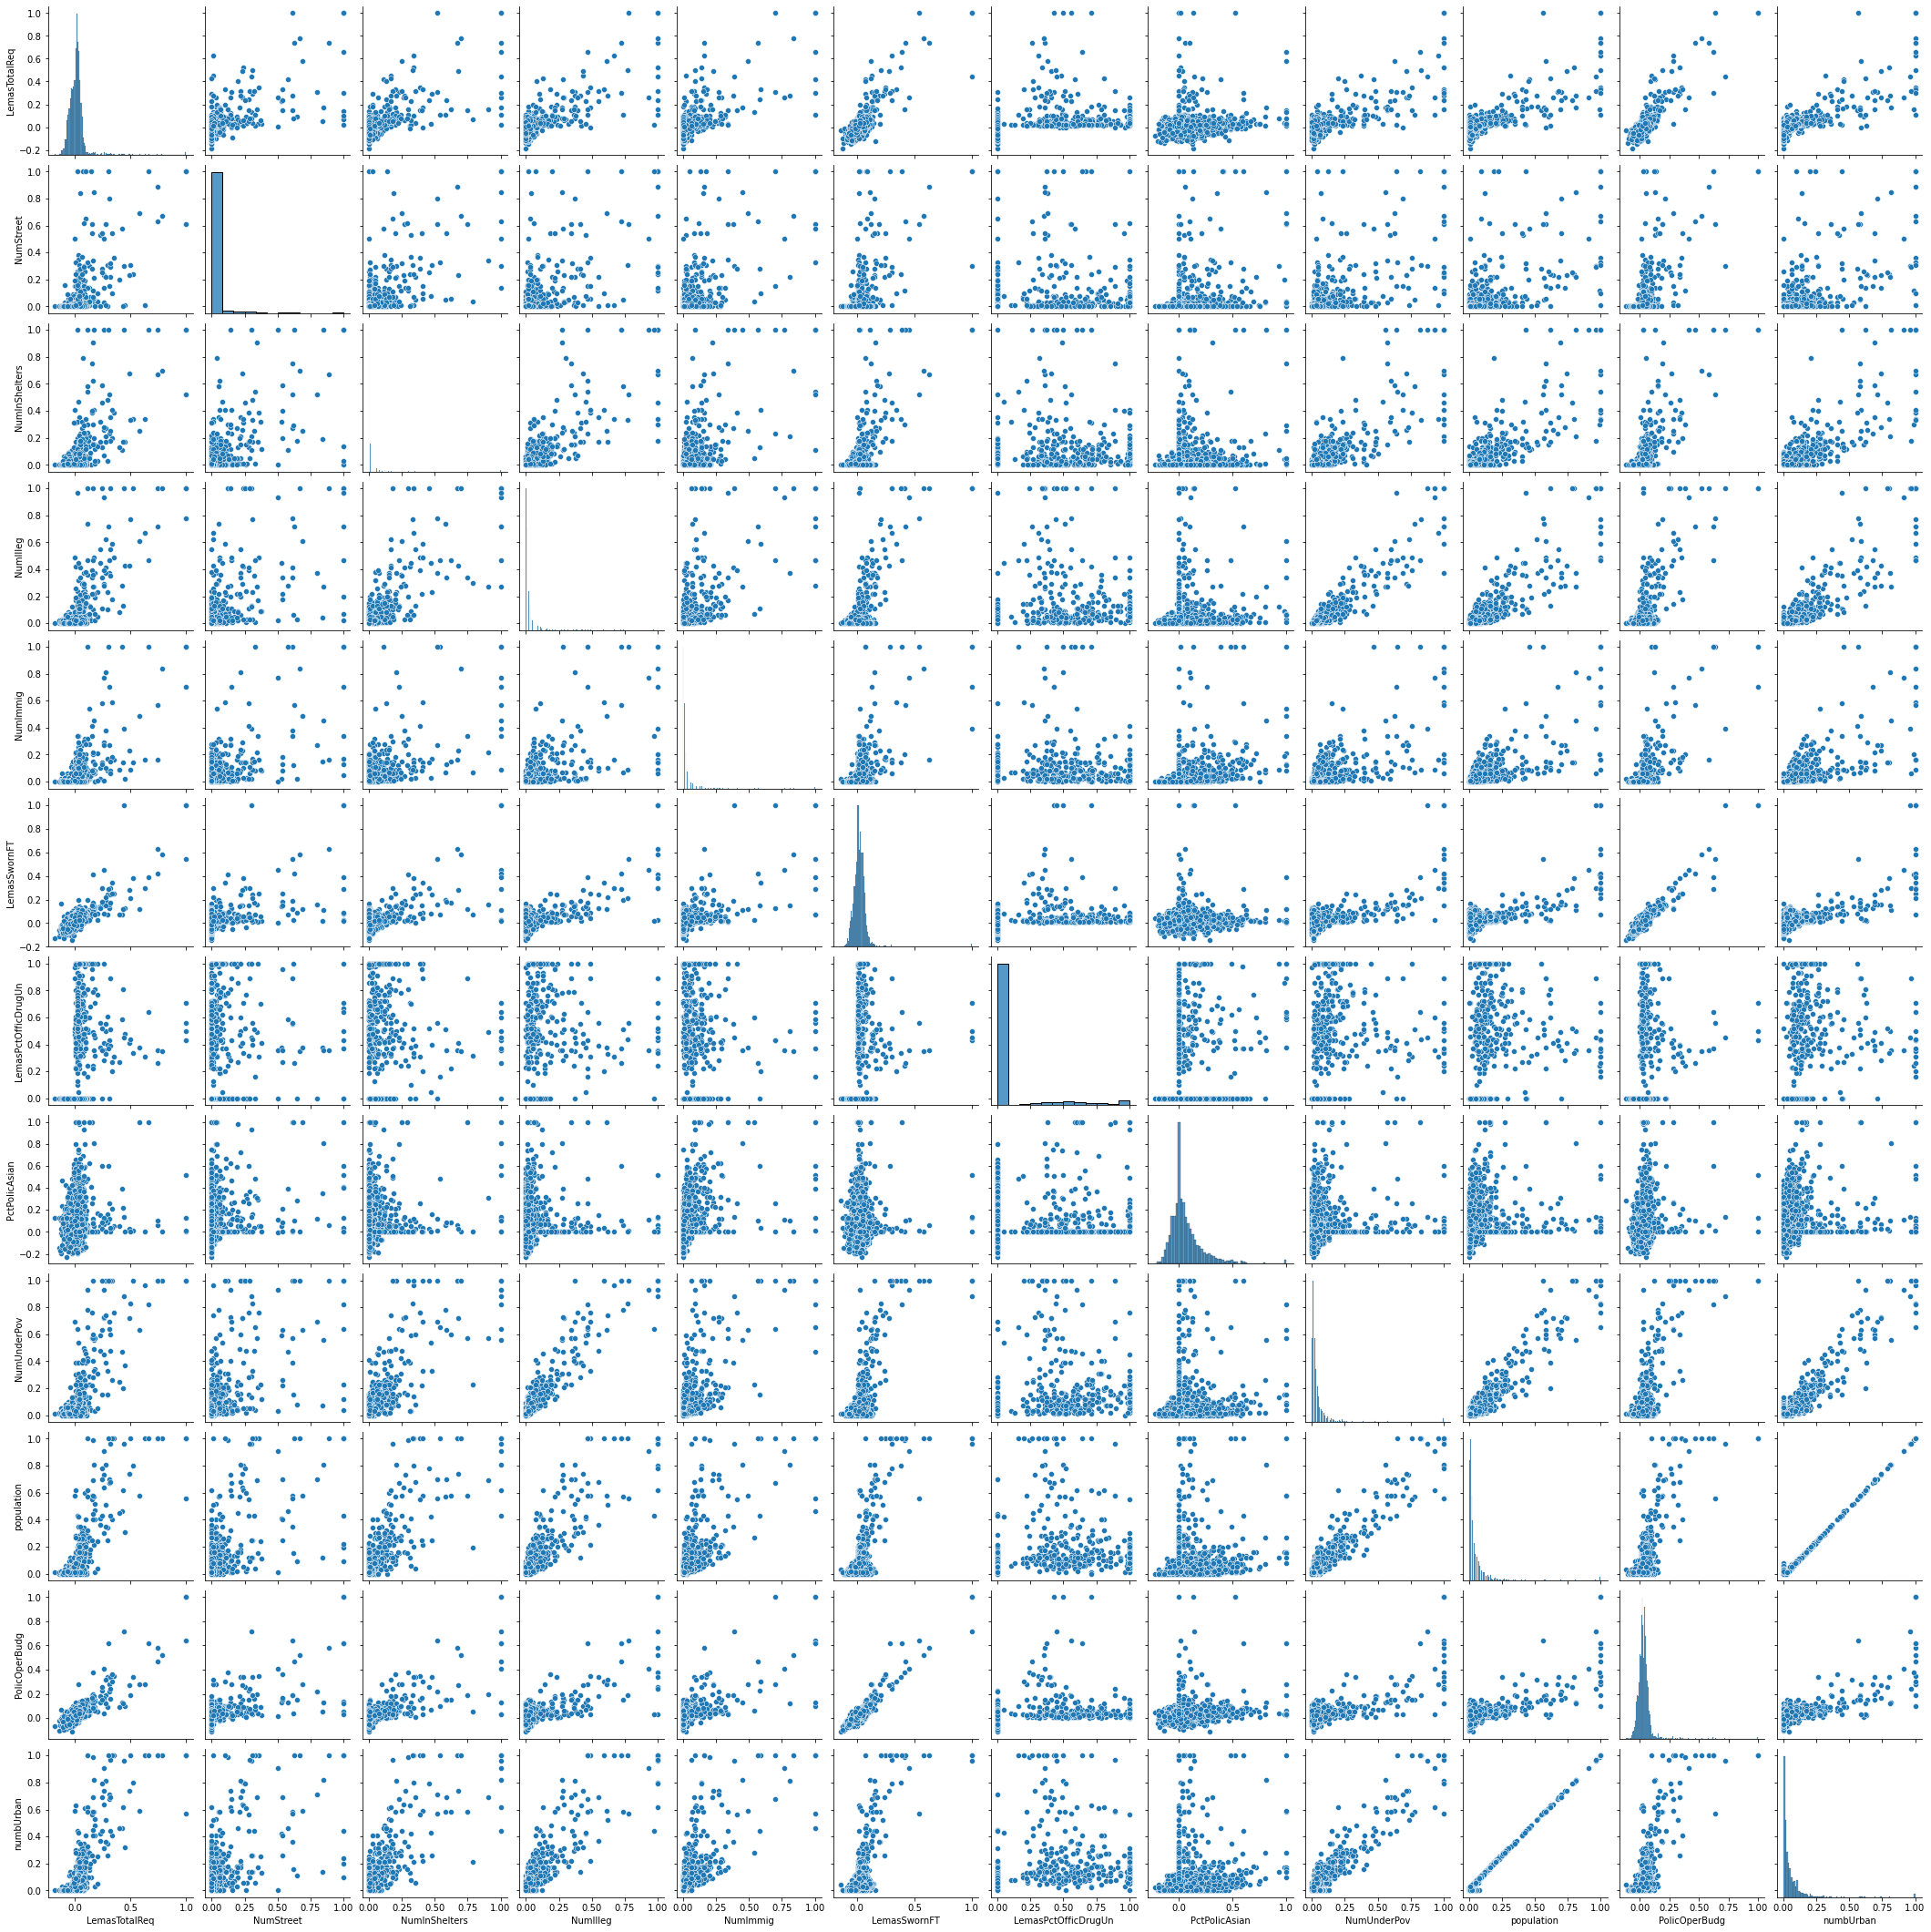

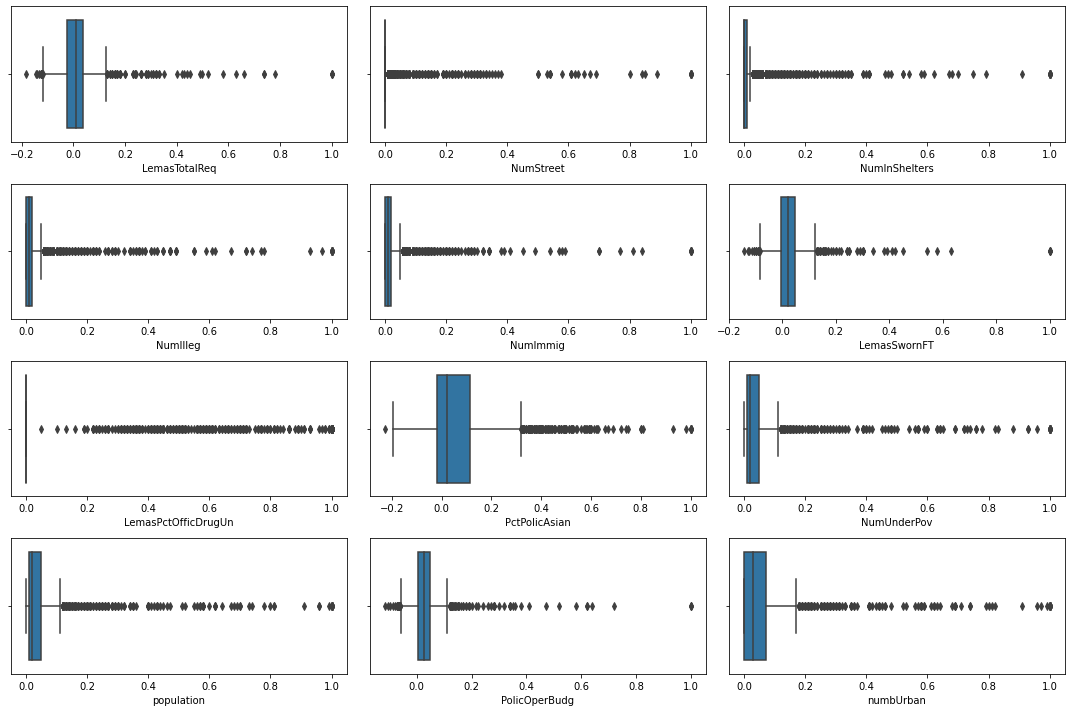

My takeaway from the scatterplots is that only population and numUrban have a strong correlation. The rest are very scattered or have weak correlations.
According to the boxplots, the only thing we can notice is that for most features, points cluster around the value of 0.2 to 0.4. Points wane as they move away from the median.


In [153]:
# sort coefficients of variation in descending order (highest to lowest)
coeff_df_sorted = coeff_df.sort_values(by='cv', ascending=False)
top_features = coeff_df_sorted.head(12) # sqrt(128) = 11.31

# scatterplot of top features
sns.pairplot(all_X[top_features['feature']])
plt.show()

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))
axes = axes.flatten()

# boxplot of top features
for i, feature in enumerate(top_features['feature']):
    sns.boxplot(x=data_imputed[feature], ax=axes[i])

plt.tight_layout()
plt.show()

print("My takeaway from the scatterplots is that only population and numUrban have a strong correlation. The rest are very scattered or have weak correlations.")
print("According to the boxplots, the only thing we can notice is that for most features, points cluster around the value of 0.2 to 0.4. Points wane as they move away from the median.")

(f) Fit a linear model using least squares to the training set and report the test error.

In [154]:
model = LinearRegression()
model.fit(X_train, Y_train)

Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

linear_train_MSE = mean_squared_error(Y_train, Y_train_pred)
linear_test_MSE = mean_squared_error(Y_test, Y_test_pred)

print(f"Train MSE: {linear_train_MSE:.4f}")
print(f"Test MSE: {linear_test_MSE:.4f}")

Train MSE: 0.0095
Test MSE: 0.0417


(g) Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.

In [155]:
# REFERENCE: Site #5
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(X_train, Y_train)

best_alpha = ridge_cv.alpha_

# fit it using best alpha
ridge = Ridge(alpha=best_alpha)
ridge_cv.fit(X_train, Y_train)

# test ridge regression model and get error
Y_pred = ridge_cv.predict(X_test)
Ridge_MSE = mean_squared_error(Y_test, Y_pred)

print(f"Best alpha: {best_alpha:.4f}")
print(f"Test MSE: {Ridge_MSE:.4f}")

Best alpha: 0.0000
Test MSE: 0.0162


(h) Fit a LASSO model on the training set, with λ chosen by cross-validation. Report the test error obtained, along with a list of the variables selected by the model. Repeat with standardized features. Report the test error for both cases and compare them.

In [156]:
results = []

# 1. NON-STANDARDIZED LASSO
lasso_cv = LassoCV(alphas=alphas, cv=10)
lasso_cv.fit(X_train, Y_train)
best_alpha_nonstandardized = lasso_cv.alpha_

# fit lasso with NON-standardized best alpha
lasso = Lasso(alpha=best_alpha_nonstandardized)
lasso.fit(X_train, Y_train)
Y_pred = lasso.predict(X_test)

Lasso_MSE_nonstandardized = mean_squared_error(Y_test, Y_pred)
variables_nonstandardized = []
for i, coef in enumerate(lasso.coef_):
    if coef != 0:
        variables_nonstandardized.append(X_train.columns[i])

results.append({"Metric": "Best Lambda (non-standardized)", "Value": best_alpha_nonstandardized})
results.append({"Metric": "Test Error (non-standardized)", "Value": Lasso_MSE_nonstandardized})
results.append({"Metric": "Num Variables (non-standardized)", "Value": len(variables_nonstandardized)})
results.append({"Metric": "Variables (non-standardized)", "Value": variables_nonstandardized})

# 2. STANDARDIZED LASSO
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso_cv_scaled = LassoCV(alphas=alphas, cv=10)
lasso_cv_scaled.fit(X_train_scaled, Y_train)

best_alpha_standardized = lasso_cv_scaled.alpha_

# fit lasso with standardized best alpha
lasso_scaled = Lasso(alpha=best_alpha_standardized)
lasso_scaled.fit(X_train_scaled, Y_train)
Y_pred_scaled = lasso_scaled.predict(X_test_scaled)

Lasso_MSE_standardized = mean_squared_error(Y_test, Y_pred_scaled)
variables_standardized = []
for i, coef in enumerate(lasso_scaled.coef_):
    if coef != 0:
        variables_standardized.append(X_train.columns[i])

results.append({"Metric": "Best Lambda (standardized)", "Value": best_alpha_standardized})
results.append({"Metric": "Test Error (standardized)", "Value": Lasso_MSE_standardized})
results.append({"Metric": "Num Variables (standardized)", "Value": len(variables_standardized)})
results.append({"Metric": "Variables (standardized)", "Value": variables_standardized})

results_df = pd.DataFrame(results)
display(results_df)

,Metric,Value
0,Best Lambda (non-standardized),0.000054
1,Test Error (non-standardized),0.014559
2,Num Variables (non-standardized),95
3,Variables (non-standardized),"[population, householdsize, racepctblack, race..."
4,Best Lambda (standardized),0.000473
5,Test Error (standardized),0.014617
6,Num Variables (standardized),85
7,Variables (standardized),"[population, racepctblack, racePctAsian, agePc..."


(i) Fit a PCR model on the training set, with M (the number of principal components) chosen by cross-validation. Report the test error obtained.

In [157]:
# REFERENCE: Site #7, #8
# determine the best number of components M
pca = PCA()
reg = LinearRegression()
pipeline = Pipeline(steps=[('pca', pca), ('reg', reg)])

num_components = range(0, X_train_scaled.shape[1], 1) # 0 to 123
param_grid = {'pca__n_components': num_components}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, Y_train)

optimal_M = grid_search.best_params_['pca__n_components']

# now actually fit the model with the optimal M from cross-validation
pca = PCA(n_components=optimal_M)
reg = LinearRegression()
model = Pipeline(steps=[('pca', pca), ('reg', reg)])
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)
PCR_MSE = mean_squared_error(Y_test, Y_pred)

print(f'PCR MSE: {PCR_MSE:.4}')
print(f'Optimal number of principal components: {optimal_M}')

PCR MSE: 0.01597
Optimal number of principal components: 94


(j) In this section, we would like to fit a boosting tree to the data. As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use L1-penalized regression at each node. Such a tree is called L1 penalized gradient boosting tree. You can use XGBoost5 to fit the model tree. Determine α (the regularization term) using cross-validation.

In [158]:
# REFERENCES: Site #9, #10
# determine best alpha for boosting tree
xgb_model = xgb.XGBRegressor(objective="reg:linear")

param_grid = {'alpha': np.logspace(-2, 2, 100)}
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, Y_train)
best_alpha = grid_search.best_params_['alpha']

# fit model with best alpha
xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=42, alpha = best_alpha)
xgb_model.fit(X_train, Y_train)

Y_pred = xgb_model.predict(X_test)
XGB_MSE = mean_squared_error(Y_test, Y_pred)

print(f"Best alpha: {best_alpha:.4f}")
print(f'The XGBoost test MSE  is: {XGB_MSE:.4f}')

Best alpha: 0.7221
The XGBoost test MSE  is: 0.0167


In [159]:
# determine which gave the best MSE
results = [
    {"Model": "Linear Regression", "MSE": linear_test_MSE},
    {"Model": "Ridge Regression", "MSE": Ridge_MSE},
    {"Model": "Lasso Regression (non-standardized)", "MSE": Lasso_MSE_nonstandardized},
    {"Model": "Lasso Regression (standardized)", "MSE": Lasso_MSE_standardized},
    {"Model": "Principal Components Regression", "MSE": PCR_MSE},
    {"Model": "XGBoost", "MSE": XGB_MSE}
]

results_df = pd.DataFrame(results)
display(results_df)

,Model,MSE
0,Linear Regression,0.041702
1,Ridge Regression,0.016161
2,Lasso Regression (non-standardized),0.014559
3,Lasso Regression (standardized),0.014617
4,Principal Components Regression,0.015975
5,XGBoost,0.016686


## References and Citations  
[#1 - Decision Tree Tutorial](https://www.w3schools.com/python/python_ml_decision_tree.asp)  
[#2 - Extracting Rules from Decision Tree](https://mljar.com/blog/extract-rules-decision-tree/)  
[#3 - Cost-Complexity Pruning Tutorial](https://vzhang1999.medium.com/classification-tree-growing-and-pruning-with-python-code-grid-search-cost-complexity-function-b2e45e33a1a4)  
[#4 - Multivariate Imputation Tutorial](https://medium.com/analytics-vidhya/a-beginners-guide-to-multivariate-imputation-fe4ae5591544)  
[#5 - RidgeCV Documentation](https://scikit-learn.org/dev/modules/generated/sklearn.linear_model.RidgeCV.html)  
[#6 - LassoCV Documentation](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LassoCV.html)  
[#7 - PCR Tutorial](https://www.geeksforgeeks.org/principal-component-regression-pcr/)  
[#8 - PCA and GridSearchCV Tutorial](https://www.kaggle.com/code/lonewolf95/classification-tutorial-with-pca-and-gridsearchcv#4.-Feature-Scaling:)  
[#9 - XGBoost Tutorial](https://www.geeksforgeeks.org/principal-component-analysis-with-python/)  
[#10 - XGBoost and GridSearchCV Tutorial](https://www.kaggle.com/code/jayatou/xgbregressor-with-gridsearchcv)  